In [11]:
import patsy as pa
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

tfd = tfp.distributions

from MakeMyPrior.elicitation_wrapper import expert_model
from MakeMyPrior.training import trainer
from MakeMyPrior.helper_functions import group_obs, Exponential_unconstrained, Normal_unconstrained
from MakeMyPrior.user_config import target_config, target_input
from MakeMyPrior.discrepancy_measures import energy_loss
from MakeMyPrior.helper_functions import print_restab, plot_priors_hyp, plot_expert_preds, group_stats
import MakeMyPrior.combine_losses 

from tabulate import tabulate
import pprint
pp = pprint.PrettyPrinter(depth=4)

tf.random.set_seed(2024)

# Case Study: Normal model

\begin{align*}
    y_i &\sim \text{Normal}(\theta_i, s)\\
    \theta_i &= \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + \beta_4x_4 + \beta_5x_5\\
    \beta_k &\sim \text{Normal}(\mu_k, \sigma_k) \quad \text{for }k=0,\ldots, 5\\
    s &\sim \text{Exponential}(\nu)
\end{align*}

## User specification

### Setting hyperparameter for the learning algorithm

In [12]:
# setting of hyperparameter of learning algorithm
user_config = dict(                    
        B = 2**8,                          
        rep = 200,                         
        epochs = 300,                      
        view_ep = 30,
        lr_decay = True,
        lr0 = 0.1, 
        lr_min = 0.0001, 
        loss_dimensions = "m,n:B",   
        loss_discrepancy = [energy_loss()]*11,       
        loss_scaling = "unscaled",         
        method = "hyperparameter_learning"  
        )

### Define the design matrix

In [13]:
# construct design matrix
X =  pa.dmatrix("a*b", pa.balanced(a = 2, b = 3, repeat = 120), return_type="dataframe")
dmatrix = tf.cast(X, dtype = tf.float32)
# extract contrast matrix from design matrix (for allocating observations to groups)
cmatrix = dmatrix[0:dmatrix.shape[1], :]

print(X)

     Intercept  a[T.a2]  b[T.b2]  b[T.b3]  a[T.a2]:b[T.b2]  a[T.a2]:b[T.b3]
0          1.0      0.0      0.0      0.0              0.0              0.0
1          1.0      0.0      1.0      0.0              0.0              0.0
2          1.0      0.0      0.0      1.0              0.0              0.0
3          1.0      1.0      0.0      0.0              0.0              0.0
4          1.0      1.0      1.0      0.0              1.0              0.0
..         ...      ...      ...      ...              ...              ...
715        1.0      0.0      1.0      0.0              0.0              0.0
716        1.0      0.0      0.0      1.0              0.0              0.0
717        1.0      1.0      0.0      0.0              0.0              0.0
718        1.0      1.0      1.0      0.0              1.0              0.0
719        1.0      1.0      0.0      1.0              0.0              1.0

[720 rows x 6 columns]


### Setup the 'ideal agent'
Define an 'arbitrary' ground truth for the hyperparameter values for method validation.

1. Define *true* hyperparameter values (for method validation; check recovery)
2. Specify for each model parameter:
    + `family`: prior distribution family
    + `initialization`: initial hyperparameter value as starting point for the learning algorithm
    + `true`: prior distributions with true hyperparameter values as defined in 1.)

In [14]:
# true hyperparameter values for ideal_expert
true_values = dict()
true_values["mu"] = [0.12, 0.15, -0.02, -0.03, -0.02, -0.04]
true_values["sigma"] = [0.02, 0.02, 0.06, 0.06, 0.03, 0.03]
true_values["nu"] = 9.

# model parameters
parameters_dict = dict()
for i in range(6):
    parameters_dict[f"beta_{i}"] = {
            "family":  Normal_unconstrained(),
            "true": tfd.Normal(true_values["mu"][i], true_values["sigma"][i]),
            "initialization": [tfd.Normal(0.,0.1)]*2
            }

exp_dist = Exponential_unconstrained(user_config["rep"])
parameters_dict["sigma"] = {
        "family": exp_dist,
        "true": exp_dist(tf.math.log(true_values["nu"])),
        "initialization": [tfd.Normal(0.,0.1)]
        }

print("True hyperparameter values:")
pp.pprint(true_values)
print("")
print("Specify prior distribution per model parameter:")
pp.pprint(parameters_dict)

True hyperparameter values:
{'mu': [0.12, 0.15, -0.02, -0.03, -0.02, -0.04],
 'nu': 9.0,
 'sigma': [0.02, 0.02, 0.06, 0.06, 0.03, 0.03]}

Specify prior distribution per model parameter:
{'beta_0': {'family': <MakeMyPrior.helper_functions.Normal_unconstrained object at 0x00000234981521D0>,
            'initialization': [<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>,
                               <tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>],
            'true': <tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>},
 'beta_1': {'family': <MakeMyPrior.helper_functions.Normal_unconstrained object at 0x0000023498016990>,
            'initialization': [<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>,
                               <tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>],
            'true': <tfp.distributions.Normal 'Normal'

### Define the data generating model

In [15]:
# generative model
class GenerativeModel(tf.Module):
    def __call__(self, 
                 parameters, # obligatory: samples from prior distributions; tf.Tensor
                 dmatrix,    # optional: design matrix; tf.Tensor
                 cmatrix,    # optional: contrast matrix; tf.Tensor
                 **kwargs    # obligatory: possibility for further keyword arguments is needed 
                 ):  
        
        # compute linear predictor term
        epred = parameters[:,:,0:6] @ tf.transpose(dmatrix)
        
        # define likelihood
        likelihood = tfd.Normal(
            loc = epred, 
            scale = tf.expand_dims(parameters[:,:,-1], -1))
        
        # sample prior predictive data
        ypred = likelihood.sample()
        
        # compute custom target quantity (here: group-differences)
        samples_grouped = group_obs(ypred, dmatrix, cmatrix)

        # compute mean difference between groups
        effect_list = []
        diffs = [(3,0), (4,1), (5,2)]
        for i in range(len(diffs)):
            # compute group difference
            diff = tf.math.subtract(
                samples_grouped[:, :, :, diffs[i][0]],
                samples_grouped[:, :, :, diffs[i][1]]
            )
            # average over individual obs within each group
            diff_mean = tf.reduce_mean(diff, axis=2)
            # collect all mean group differences
            effect_list.append(diff_mean)

        mean_effects = tf.stack(effect_list, axis=-1)
        
        return dict(likelihood = likelihood,      # obligatory: likelihood; callable
                    ypred = ypred,                # obligatory: prior predictive data
                    epred = epred,                # obligatory: samples from linear predictor
                    mean_effects = mean_effects   # optional: custom target quantity
                    )

### Specify the target quantities and the elicitation technique

In [16]:
 # define a custom function using the output from the generative model   
def custom_r2(ypred, epred, **kwargs):
    return tf.math.divide(tf.math.reduce_variance(epred, axis = -1), 
                          tf.math.reduce_variance(ypred, axis = -1))

# specify target quantity, elicitation technique and loss combination
t1 = target_config(target="R2", 
                   elicitation="histogram",
                   combine_loss="all",
                   custom_target_function = custom_r2)
t2 = target_config(target="group_means", 
                   elicitation="quantiles", 
                   combine_loss="by-group", 
                   quantiles_specs = (10, 20, 30, 40, 50, 60, 70, 80, 90))
t3 = target_config(target="mean_effects", 
                   elicitation="quantiles",
                   combine_loss="by-group",
                   quantiles_specs = (10, 20, 30, 40, 50, 60, 70, 80, 90))
t4 = target_config(target="grand_mean", 
                   elicitation="histogram",
                   combine_loss="all") 

target_info = target_input(t1, t2, t3)

pp.pprint(target_info)

{'combine_loss': ['all', 'by-group', 'by-group'],
 'custom_target_function': [<function custom_r2 at 0x00000234EB4949A0>,
                            None,
                            None],
 'elicitation': ['histogram', 'quantiles', 'quantiles'],
 'internal_loss': [None, None, None],
 'quantiles_specs': [(10, 20, 30, 40, 50, 60, 70, 80, 90),
                     (10, 20, 30, 40, 50, 60, 70, 80, 90)],
 'target': ['R2', 'group_means', 'mean_effects']}


## Expert model

In [17]:
expert_res_list, prior_pred_res = expert_model(1, user_config["rep"],
                                   parameters_dict, GenerativeModel, target_info,
                                   method = "ideal_expert",
                                   dmatrix = dmatrix,
                                   cmatrix = cmatrix,
                                   dmatrix_fct = dmatrix)

# elicited statistics from the (ideal) expert
expert_res_list.keys()

dict_keys(['R2_hist_0', 'group_means_quant_1', 'mean_effects_quant_2'])

### Expert predictions

In [18]:
# group means
print(group_stats(prior_pred_res["ypred"], num_groups = 6))
# mean effects
print("mean effects:")
print(np.round(tf.reduce_mean(prior_pred_res["mean_effects"],(0,1)),2))

+-------+------+------+
| group | mean | std  |
+-------+------+------+
|  gr_0 | 0.12 | 0.02 |
|  gr_1 | 0.1  | 0.06 |
|  gr_2 | 0.09 | 0.07 |
|  gr_3 | 0.27 | 0.03 |
|  gr_4 | 0.22 | 0.07 |
|  gr_5 | 0.2  | 0.08 |
+-------+------+------+
mean effects:
[0.15 0.13 0.11]


C:\Users\flobo\MakeMyPrior\MakeMyPrior\helper_functions.py:417: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(["r","new: deep","new: standard","new: shallow","rep: deep","rep: standard","rep: shallow"])


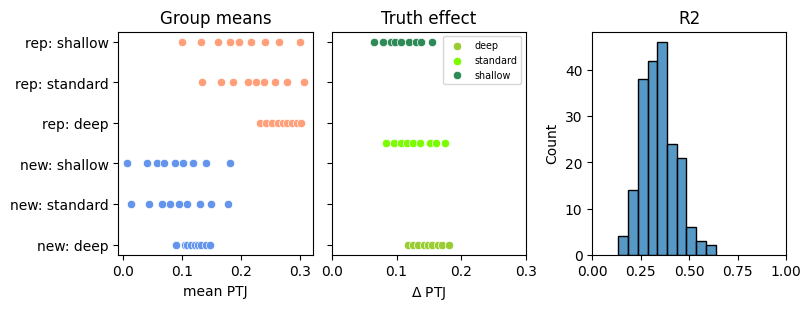

In [19]:
# plot expert predictions
plot_expert_preds(expert_res_list)

## Learning Algorithm

In [20]:
res_dict = trainer(expert_res_list, user_config["B"], user_config["rep"],
                   parameters_dict, user_config["method"], GenerativeModel,
                   target_info, user_config, loss_balancing = True, save_vals = ["prior_preds"],
                   dmatrix = dmatrix, cmatrix = cmatrix, dmatrix_fct = dmatrix)

epoch_time: 1062.938ms
Epoch: 0, loss: 0.80136, lr: 0.100000
epoch_time: 244.903ms
Epoch: 30, loss: 0.12183, lr: 0.053144
epoch_time: 282.745ms
Epoch: 60, loss: 0.04244, lr: 0.028243
epoch_time: 267.483ms
Epoch: 90, loss: 0.02091, lr: 0.015009
epoch_time: 264.304ms
Epoch: 120, loss: 0.01540, lr: 0.007977
epoch_time: 259.083ms
Epoch: 150, loss: 0.01767, lr: 0.004239
epoch_time: 273.342ms
Epoch: 180, loss: 0.02404, lr: 0.002253
epoch_time: 257.814ms
Epoch: 210, loss: 0.01377, lr: 0.001197
epoch_time: 267.489ms
Epoch: 240, loss: 0.01493, lr: 0.000636
epoch_time: 286.409ms
Epoch: 270, loss: 0.01584, lr: 0.000338


### Training results

#### Loss

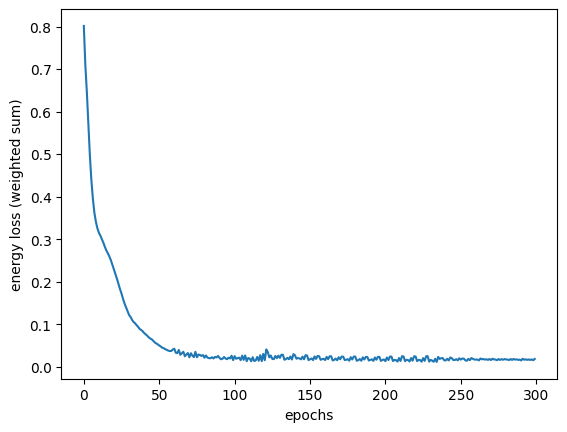

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(len(res_dict["loss_info"])), res_dict["loss_info"]) 
plt.xlabel("epochs")
plt.ylabel("energy loss (weighted sum)")
plt.show()

#### Learned hyperparameter values

In [22]:
true_vals = [j for i in zip(true_values["mu"],true_values["sigma"]) for j in i]
true_vals += [true_values["nu"]]

tab, avg_res = print_restab(method = "hyperparameter_learning", 
                             num_vars = 13, 
                             res = res_dict["hyperparam_info"], 
                             start = 10, 
                             precision = 3, 
                             true_values = true_vals)
tab

var_name,pred mean,pred std,true,err
loc_0,0.12,0.006,0.12,0.0
scale_0,0.024,0.0,0.02,0.004
loc_1,0.148,0.007,0.15,0.002
scale_1,0.023,0.0,0.02,0.003
loc_2,-0.027,0.006,-0.02,0.007
scale_2,0.062,0.0,0.06,0.002
loc_3,-0.033,0.006,-0.03,0.003
scale_3,0.064,0.0,0.06,0.004
loc_4,-0.022,0.006,-0.02,0.002
scale_4,0.031,0.0,0.03,0.001


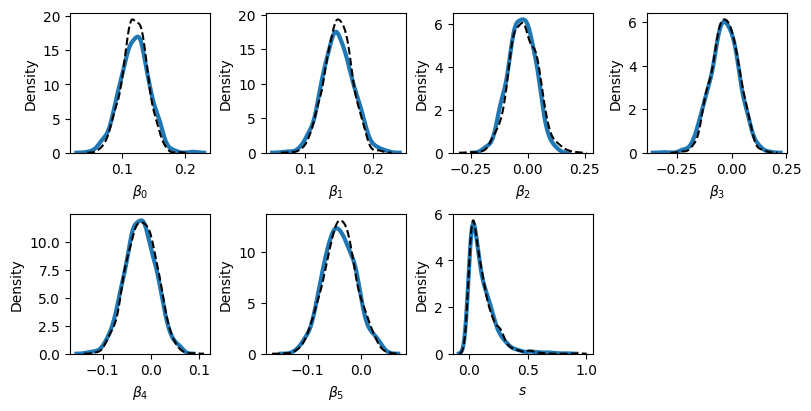

In [23]:
plot_priors_hyp(avg_res, true_values)